In [1]:
!pip install numpy pandas tensorflow 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(5)
tf.random.set_seed(5)

# Configuration
ACTIVATIONS = ['relu', 'tanh', 'softplus', 'sigmoid']
HIDDEN_UNITS = [8, 13, 20]  #neuron counts
EPOCHS = 200
BATCH_SIZE = 8
PATIENCE = 20

In [5]:
#Load data and create 3-way split (Train/Validation/Test)
dataset = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print(" Data loaded successfully!")
print(f"Dataset shape: {dataset.shape}")

# Prepare features (X) and targets (y)
X = dataset.iloc[:, 1:5].values   # Factor A, B, C, D
y = dataset.iloc[:, 5:7].values   # Response 1 and Response 2

# STEP 1: First split - separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# STEP 2: Second split - from remaining 80%, take 20% for validation
# This gives us: 64% train, 16% validation, 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")

# Normalize the data
scaler_X = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))  

# Fit scalers only on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

 Data loaded successfully!
Dataset shape: (25, 7)
Training set: 16 samples (64.0%)
Validation set: 4 samples (16.0%)
Test set: 5 samples (20.0%)
Total: 25 samples


In [6]:
#Neural Network
def create_enhanced_nn(neurons, activation):
    """Create neural network with specified activation"""
    model = Sequential([
        Input(shape=(4,)),
        Dense(neurons, activation=activation),
        Dense(2, activation='tanh')  # Output layer with tanh for (-1,1) range
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

print("\n NEURAL NETWORK GRID SEARCH")

print("Testing all combinations of activations and neurons...")

# Store results for all combinations
nn_results = {}
best_config = {'val_loss': float('inf'), 'activation': None, 'neurons': None, 'model': None}

total_combinations = len(ACTIVATIONS) * len(HIDDEN_UNITS)
current_combo = 0

for activation in ACTIVATIONS:
    for neurons in HIDDEN_UNITS:
        current_combo += 1
        
        # Clear previous model to save memory
        tf.keras.backend.clear_session()
        
        config_name = f"{activation}_{neurons}"
        print(f"\n[{current_combo}/{total_combinations}] Testing: {activation} activation, {neurons} neurons")
        
        # Create and train model
        model = create_enhanced_nn(neurons, activation)
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=PATIENCE, 
            restore_best_weights=True,
            verbose=0
        )
        
        # Train the model
        history = model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # Get final validation loss
        val_loss = min(history.history['val_loss'])
        final_epoch = len(history.history['loss'])
        
        # Make predictions on validation set
        y_pred_val_scaled = model.predict(X_val_scaled, verbose=0)
        y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled)
        
        # Calculate metrics
        val_r2 = r2_score(y_val, y_pred_val)
        val_mse = mean_squared_error(y_val, y_pred_val)
        val_mae = mean_absolute_error(y_val, y_pred_val)
        
        # Store results
        nn_results[config_name] = {
            'activation': activation,
            'neurons': neurons,
            'val_loss': val_loss,
            'val_r2': val_r2,
            'val_mse': val_mse,
            'val_mae': val_mae,
            'epochs_trained': final_epoch,
            'history': history
        }
        
        print(f"  Validation R² = {val_r2:.4f}, MSE = {val_mse:.4f}, Epochs = {final_epoch}")
        
        # Track best model
        if val_loss < best_config['val_loss']:
            best_config.update({
                'val_loss': val_loss,
                'activation': activation,
                'neurons': neurons,
                'model': model,
                'config_name': config_name
            })

print(f"\ BEST CONFIGURATION:")
print(f"Activation: {best_config['activation']}")
print(f"Neurons: {best_config['neurons']}")
print(f"Validation Loss: {best_config['val_loss']:.6f}")
print(f"Config Name: {best_config['config_name']}")


 NEURAL NETWORK GRID SEARCH
Testing all combinations of activations and neurons...


[1/12] Testing: relu activation, 8 neurons
  Validation R² = -7.4294, MSE = 420682.8904, Epochs = 33

[2/12] Testing: relu activation, 13 neurons
  Validation R² = -13.4223, MSE = 668837.7338, Epochs = 90

[3/12] Testing: relu activation, 20 neurons
  Validation R² = -15.2650, MSE = 665720.0371, Epochs = 74

[4/12] Testing: tanh activation, 8 neurons
  Validation R² = -10.9570, MSE = 535112.7950, Epochs = 106

[5/12] Testing: tanh activation, 13 neurons
  Validation R² = -19.1233, MSE = 780218.2916, Epochs = 89

[6/12] Testing: tanh activation, 20 neurons
  Validation R² = -6.0768, MSE = 311866.5868, Epochs = 40

[7/12] Testing: softplus activation, 8 neurons
  Validation R² = -5.8808, MSE = 269038.3715, Epochs = 58

[8/12] Testing: softplus activation, 13 neurons
  Validation R² = -8.0914, MSE = 405144.3127, Epochs = 44

[9/12] Testing: softplus activation, 20 neurons
  Validation R² = -1.9951, MSE =

In [7]:
#Create results table and train SVM
print("\n NEURAL NETWORK RESULTS SUMMARY:")


# Create comprehensive results table
results_data = []
for config_name, results in nn_results.items():
    results_data.append({
        'Activation': results['activation'],
        'Neurons': results['neurons'],
        'Val R²': results['val_r2'],
        'Val MSE': results['val_mse'],
        'Val MAE': results['val_mae'],
        'Epochs': results['epochs_trained']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Val R²', ascending=False)
print(results_df.round(4))

print(f"\n BEST: {best_config['activation']} with {best_config['neurons']} neurons")

# Train SVM for comparison
print("\n SUPPORT VECTOR MACHINE COMPARISON:")


# SVM works better with StandardScaler, so let's use the original scaling
scaler_X_svm = StandardScaler()
scaler_y_svm = StandardScaler()

X_train_svm = scaler_X_svm.fit_transform(X_train)
y_train_svm = scaler_y_svm.fit_transform(y_train)
X_val_svm = scaler_X_svm.transform(X_val)
y_val_svm = scaler_y_svm.transform(y_val)
X_test_svm = scaler_X_svm.transform(X_test)

# Train SVM
svm_model = MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma='scale'))
svm_model.fit(X_train_svm, y_train_svm)

# SVM predictions on validation
y_pred_val_svm_scaled = svm_model.predict(X_val_svm)
y_pred_val_svm = scaler_y_svm.inverse_transform(y_pred_val_svm_scaled)

# SVM metrics
svm_val_r2 = r2_score(y_val, y_pred_val_svm)
svm_val_mse = mean_squared_error(y_val, y_pred_val_svm)
svm_val_mae = mean_absolute_error(y_val, y_pred_val_svm)

print(f"SVM Validation R² = {svm_val_r2:.4f}")
print(f"SVM Validation MSE = {svm_val_mse:.4f}")
print(f"SVM Validation MAE = {svm_val_mae:.4f}")

# FINAL TEST PREDICTIONS
print("\n FINAL TEST SET PREDICTIONS:")

# Best Neural Network on test set
best_model = best_config['model']
y_pred_test_nn_scaled = best_model.predict(X_test_scaled, verbose=0)
y_pred_test_nn = scaler_y.inverse_transform(y_pred_test_nn_scaled)

# SVM on test set
y_test_svm = scaler_y_svm.transform(y_test)
y_pred_test_svm_scaled = svm_model.predict(X_test_svm)
y_pred_test_svm = scaler_y_svm.inverse_transform(y_pred_test_svm_scaled)

# Test set metrics
nn_test_r2 = r2_score(y_test, y_pred_test_nn)
nn_test_mse = mean_squared_error(y_test, y_pred_test_nn)
nn_test_mae = mean_absolute_error(y_test, y_pred_test_nn)

svm_test_r2 = r2_score(y_test, y_pred_test_svm)
svm_test_mse = mean_squared_error(y_test, y_pred_test_svm)
svm_test_mae = mean_absolute_error(y_test, y_pred_test_svm)

print("NEURAL NETWORK (Best Config):")
print(f"  Test R² = {nn_test_r2:.4f}")
print(f"  Test MSE = {nn_test_mse:.4f}")
print(f"  Test MAE = {nn_test_mae:.4f}")

print("\nSUPPORT VECTOR MACHINE:")
print(f"  Test R² = {svm_test_r2:.4f}")
print(f"  Test MSE = {svm_test_mse:.4f}")
print(f"  Test MAE = {svm_test_mae:.4f}")

# Determine winner
if nn_test_r2 > svm_test_r2:
    print(f"\n Best Neural Network ({best_config['activation']}, {best_config['neurons']} neurons)")
    print(f"   R² advantage: {nn_test_r2 - svm_test_r2:.4f}")
else:
    print(f"\n Best Support Vector Machine")
    print(f"   R² advantage: {svm_test_r2 - nn_test_r2:.4f}")


 NEURAL NETWORK RESULTS SUMMARY:
   Activation  Neurons   Val R²      Val MSE   Val MAE  Epochs
8    softplus       20  -1.9951  171060.9298  335.1800      75
9     sigmoid        8  -2.7548  190397.3025  363.2414      36
11    sigmoid       20  -3.4798  191566.9099  383.6457      60
6    softplus        8  -5.8808  269038.3715  405.9837      58
5        tanh       20  -6.0768  311866.5868  444.8371      40
10    sigmoid       13  -6.5700  327860.7230  487.8287      72
0        relu        8  -7.4294  420682.8904  430.6091      33
7    softplus       13  -8.0914  405144.3127  480.3679      44
3        tanh        8 -10.9570  535112.7950  548.9544     106
1        relu       13 -13.4223  668837.7338  725.3077      90
2        relu       20 -15.2650  665720.0371  618.8442      74
4        tanh       13 -19.1233  780218.2916  697.0547      89

 BEST: sigmoid with 20 neurons

 SUPPORT VECTOR MACHINE COMPARISON:
SVM Validation R² = -27.6100
SVM Validation MSE = 1181384.0113
SVM Validation 

In [10]:
# CELL 5: Detailed prediction tables and comparison
print("\n DETAILED PREDICTION TABLES:")


# Neural Network predictions table
print(f" NEURAL NETWORK PREDICTIONS ({best_config['activation']}, {best_config['neurons']} neurons):")
nn_predictions_df = pd.DataFrame({
    'Test Sample': range(1, len(y_test) + 1),
    'Actual Response 1': y_test[:, 0],
    'NN Pred Response 1': y_pred_test_nn[:, 0],
    'NN Error Resp 1': np.abs(y_test[:, 0] - y_pred_test_nn[:, 0]),
    'Actual Response 2': y_test[:, 1],
    'NN Pred Response 2': y_pred_test_nn[:, 1],
    'NN Error Resp 2': np.abs(y_test[:, 1] - y_pred_test_nn[:, 1])
})
print(nn_predictions_df.round(2))

print(f"\n🔬 SVM PREDICTIONS:")
svm_predictions_df = pd.DataFrame({
    'Test Sample': range(1, len(y_test) + 1),
    'Actual Response 1': y_test[:, 0],
    'SVM Pred Response 1': y_pred_test_svm[:, 0],
    'SVM Error Resp 1': np.abs(y_test[:, 0] - y_pred_test_svm[:, 0]),
    'Actual Response 2': y_test[:, 1],
    'SVM Pred Response 2': y_pred_test_svm[:, 1],
    'SVM Error Resp 2': np.abs(y_test[:, 1] - y_pred_test_svm[:, 1])
})
print(svm_predictions_df.round(2))

# Individual response R² scores
nn_r2_resp1 = r2_score(y_test[:, 0], y_pred_test_nn[:, 0])
nn_r2_resp2 = r2_score(y_test[:, 1], y_pred_test_nn[:, 1])
svm_r2_resp1 = r2_score(y_test[:, 0], y_pred_test_svm[:, 0])
svm_r2_resp2 = r2_score(y_test[:, 1], y_pred_test_svm[:, 1])

print(f"\n DETAILED R² BREAKDOWN:")
comparison_df = pd.DataFrame({
    'Model': ['Neural Network (Best)', 'SVM'],
    'Response 1 R²': [nn_r2_resp1, svm_r2_resp1],
    'Response 2 R²': [nn_r2_resp2, svm_r2_resp2],
    'Overall R²': [nn_test_r2, svm_test_r2],
    'Overall MSE': [nn_test_mse, svm_test_mse],
    'Overall MAE': [nn_test_mae, svm_test_mae]
})
print(comparison_df.round(4))

# Show how different activations performed
print(f"\n ACTIVATION FUNCTION PERFORMANCE RANKING:")
activation_summary = results_df.groupby('Activation').agg({
    'Val R²': ['mean', 'max', 'min'],
    'Val MSE': ['mean', 'min', 'max']
}).round(4)
activation_summary.columns = ['Avg R²', 'Best R²', 'Worst R²', 'Avg MSE', 'Best MSE', 'Worst MSE']
activation_summary = activation_summary.sort_values('Avg R²', ascending=False)
print(activation_summary)

print(f"\n INSIGHTS:")

best_activation = activation_summary.index[0]
worst_activation = activation_summary.index[-1]
print(f"• Best activation overall: {best_activation}")
print(f"• Worst activation overall: {worst_activation}")
print(f"• Best single config: {best_config['activation']} with {best_config['neurons']} neurons")
print(f"• Neural Network vs SVM: {'NN wins' if nn_test_r2 > svm_test_r2 else 'SVM wins'}")

if len(set([r['neurons'] for r in nn_results.values()])) > 1:
    # Check if neuron count matters
    neuron_performance = results_df.groupby('Neurons')['Val R²'].mean().sort_values(ascending=False)
    print(f"• Best neuron count on average: {neuron_performance.index[0]}")


 DETAILED PREDICTION TABLES:
 NEURAL NETWORK PREDICTIONS (sigmoid, 13 neurons):
   Test Sample  Actual Response 1  NN Pred Response 1  NN Error Resp 1  \
0            1            2298.62         2564.530029           265.91   
1            2            3762.88         2557.389893          1205.49   
2            3            1127.19         2234.679932          1107.49   
3            4            2955.83         2493.580078           462.25   
4            5            2322.83         2267.310059            55.52   

   Actual Response 2  NN Pred Response 2  NN Error Resp 2  
0            2972.98         3202.469971           229.49  
1            5752.81         3211.620117          2541.19  
2            1321.65         2884.629883          1562.98  
3            2966.91         3332.919922           366.01  
4            2987.31         3121.510010           134.20  

🔬 SVM PREDICTIONS:
   Test Sample  Actual Response 1  SVM Pred Response 1  SVM Error Resp 1  \
0            1    

In [8]:
#Linear Regression Baseline Comparison
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

print("\nLINEAR REGRESSION BASELINE")

print("Adding the simplest model as baseline comparison...")

# Create and train Linear Regression model
lr_model = MultiOutputRegressor(LinearRegression())

# Train on the same training data (using StandardScaler - better for Linear Regression)
lr_model.fit(X_train_svm, y_train_svm)  # Using the StandardScaler data from Cell 4

# Predictions on validation set
y_pred_val_lr_scaled = lr_model.predict(X_val_svm)
y_pred_val_lr = scaler_y_svm.inverse_transform(y_pred_val_lr_scaled)

# Predictions on test set  
y_pred_test_lr_scaled = lr_model.predict(X_test_svm)
y_pred_test_lr = scaler_y_svm.inverse_transform(y_pred_test_lr_scaled)

# Calculate metrics
lr_val_r2 = r2_score(y_val, y_pred_val_lr)
lr_val_mse = mean_squared_error(y_val, y_pred_val_lr)
lr_val_mae = mean_absolute_error(y_val, y_pred_val_lr)

lr_test_r2 = r2_score(y_test, y_pred_test_lr)
lr_test_mse = mean_squared_error(y_test, y_pred_test_lr)
lr_test_mae = mean_absolute_error(y_test, y_pred_test_lr)

# Individual response R² scores
lr_r2_resp1 = r2_score(y_test[:, 0], y_pred_test_lr[:, 0])
lr_r2_resp2 = r2_score(y_test[:, 1], y_pred_test_lr[:, 1])

print("VALIDATION SET PERFORMANCE:")
print(f"  Linear Regression R² = {lr_val_r2:.4f}")
print(f"  Linear Regression MSE = {lr_val_mse:.4f}")
print(f"  Linear Regression MAE = {lr_val_mae:.4f}")

print("\nTEST SET PERFORMANCE:")
print(f"  Linear Regression R² = {lr_test_r2:.4f}")
print(f"  Linear Regression MSE = {lr_test_mse:.4f}")  
print(f"  Linear Regression MAE = {lr_test_mae:.4f}")

print(f"\nINDIVIDUAL RESPONSE PERFORMANCE:")
print(f"  Response 1 R² = {lr_r2_resp1:.4f}")
print(f"  Response 2 R² = {lr_r2_resp2:.4f}")

# Linear Regression predictions table
print(f"\n📊 LINEAR REGRESSION PREDICTIONS:")
lr_predictions_df = pd.DataFrame({
    'Test Sample': range(1, len(y_test) + 1),
    'Actual Response 1': y_test[:, 0],
    'LR Pred Response 1': y_pred_test_lr[:, 0],
    'LR Error Resp 1': np.abs(y_test[:, 0] - y_pred_test_lr[:, 0]),
    'Actual Response 2': y_test[:, 1],
    'LR Pred Response 2': y_pred_test_lr[:, 1],
    'LR Error Resp 2': np.abs(y_test[:, 1] - y_pred_test_lr[:, 1])
})
print(lr_predictions_df.round(2))

# Updated comprehensive comparison
print(f"\n COMPLETE MODEL COMPARISON (All 4 Models):")
complete_comparison_df = pd.DataFrame({
    'Model': [
        f'Neural Network ({best_config["activation"]}, {best_config["neurons"]})',
        'Support Vector Machine', 
        'Linear Regression',
        'Ranking by R²'
    ],
    'Response 1 R²': [nn_r2_resp1, svm_r2_resp1, lr_r2_resp1, ''],
    'Response 2 R²': [nn_r2_resp2, svm_r2_resp2, lr_r2_resp2, ''],
    'Overall R²': [nn_test_r2, svm_test_r2, lr_test_r2, ''],
    'Overall MSE': [nn_test_mse, svm_test_mse, lr_test_mse, ''],
    'Overall MAE': [nn_test_mae, svm_test_mae, lr_test_mae, '']
})

# Remove the ranking row for now, add it after sorting
comparison_for_sorting = complete_comparison_df.iloc[:-1].copy()
comparison_for_sorting['Overall R²'] = pd.to_numeric(comparison_for_sorting['Overall R²'])
comparison_sorted = comparison_for_sorting.sort_values('Overall R²', ascending=False)

print(comparison_sorted.round(4))

# Determine the winner and rankings
models_r2 = [
    ('Neural Network', nn_test_r2),
    ('SVM', svm_test_r2), 
    ('Linear Regression', lr_test_r2)
]
models_r2.sort(key=lambda x: x[1], reverse=True)

print(f"\n FINAL RANKINGS (by Test R²):")

for i, (model, r2) in enumerate(models_r2):
    print(f" {model}: R² = {r2:.4f}")

# Check if complex models beat the baseline
if lr_test_r2 > max(nn_test_r2, svm_test_r2):
    print(f"\n  WARNING: Linear Regression outperforms complex models!")
    print("   This suggests your data might have simple linear relationships.")
    print("   Complex models may be overfitting or unnecessary.")
elif max(nn_test_r2, svm_test_r2) - lr_test_r2 < 0.05:
    print(f"\n INFO: Complex models only slightly better than Linear Regression")
    print(f"   Improvement: {max(nn_test_r2, svm_test_r2) - lr_test_r2:.4f}")
    print("   Linear model might be sufficient for this dataset.")
else:
    print(f"\n Complex models successfully outperform Linear Regression baseline")
    print(f"   Best improvement: {max(nn_test_r2, svm_test_r2) - lr_test_r2:.4f}")

# Show model coefficients (feature importance)
print(f"\n LINEAR REGRESSION COEFFICIENTS (Feature Importance):")
feature_names = ['Factor A', 'Factor B', 'Factor C', 'Factor D']

print("\nResponse 1 coefficients:")
for i, coef in enumerate(lr_model.estimators_[0].coef_):
    print(f"  {feature_names[i]}: {coef:.4f}")

print("\nResponse 2 coefficients:")  
for i, coef in enumerate(lr_model.estimators_[1].coef_):
    print(f"  {feature_names[i]}: {coef:.4f}")

print(f"\nIntercepts:")
print(f"  Response 1: {lr_model.estimators_[0].intercept_:.4f}")
print(f"  Response 2: {lr_model.estimators_[1].intercept_:.4f}")


LINEAR REGRESSION BASELINE
Adding the simplest model as baseline comparison...
VALIDATION SET PERFORMANCE:
  Linear Regression R² = -26.9157
  Linear Regression MSE = 1217354.2360
  Linear Regression MAE = 719.2791

TEST SET PERFORMANCE:
  Linear Regression R² = -0.1708
  Linear Regression MSE = 1548504.3780
  Linear Regression MAE = 1011.8012

INDIVIDUAL RESPONSE PERFORMANCE:
  Response 1 R² = -0.3035
  Response 2 R² = -0.0382

📊 LINEAR REGRESSION PREDICTIONS:
   Test Sample  Actual Response 1  LR Pred Response 1  LR Error Resp 1  \
0            1            2298.62             4127.39          1828.77   
1            2            3762.88             4240.42           477.54   
2            3            1127.19             2088.84           961.65   
3            4            2955.83             3548.15           592.32   
4            5            2322.83             2095.67           227.16   

   Actual Response 2  LR Pred Response 2  LR Error Resp 2  
0            2972.98        

NameError: name 'nn_r2_resp1' is not defined

NameError: name 'nn_r2_resp1' is not defined

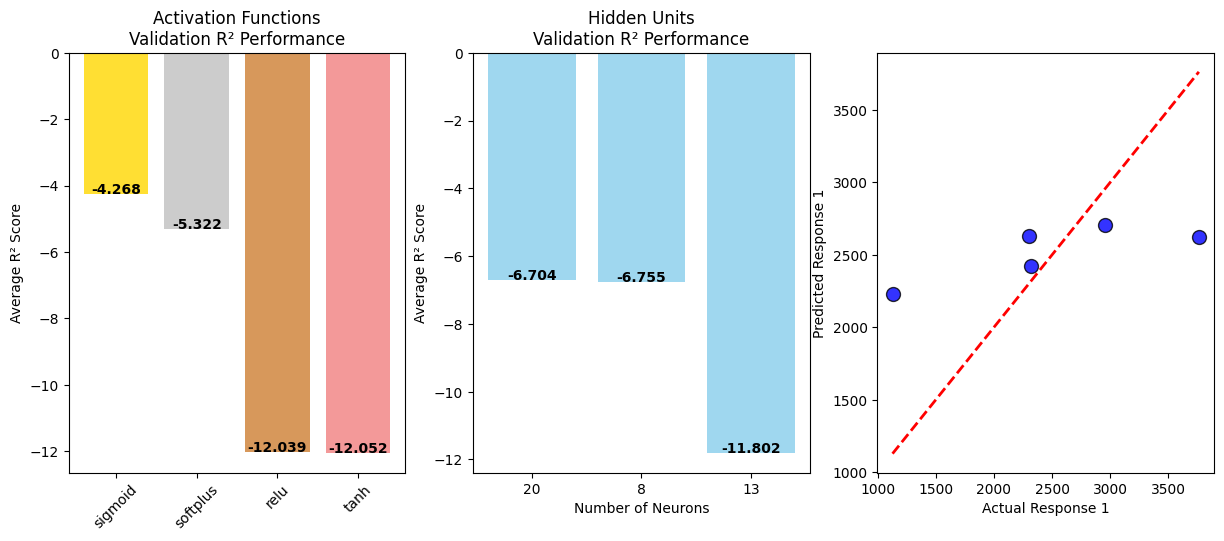

In [9]:
#  Create comprehensive visualizations
plt.figure(figsize=(20, 12))

# Plot 1: Activation Function Comparison
plt.subplot(2, 4, 1)
activation_means = results_df.groupby('Activation')['Val R²'].mean().sort_values(ascending=False)
colors = ['gold', 'silver', '#CD7F32', 'lightcoral'][:len(activation_means)]
bars = plt.bar(activation_means.index, activation_means.values, color=colors, alpha=0.8)
plt.title('Activation Functions\nValidation R² Performance')
plt.ylabel('Average R² Score')
plt.xticks(rotation=45)
for i, v in enumerate(activation_means.values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Neuron Count Comparison  
plt.subplot(2, 4, 2)
neuron_means = results_df.groupby('Neurons')['Val R²'].mean().sort_values(ascending=False)
plt.bar(neuron_means.index.astype(str), neuron_means.values, color='skyblue', alpha=0.8)
plt.title('Hidden Units\nValidation R² Performance') 
plt.ylabel('Average R² Score')
plt.xlabel('Number of Neurons')
for i, v in enumerate(neuron_means.values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Best NN Response 1 - Actual vs Predicted
plt.subplot(2, 4, 3)
plt.scatter(y_test[:, 0], y_pred_test_nn[:, 0], alpha=0.8, color='blue', s=100, edgecolor='black')
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2)
plt.xlabel('Actual Response 1')
plt.ylabel('Predicted Response 1')
plt.title(f'Best NN - Response 1\nR² = {nn_r2_resp1:.3f}')

# Plot 4: Best NN Response 2 - Actual vs Predicted
plt.subplot(2, 4, 4)
plt.scatter(y_test[:, 1], y_pred_test_nn[:, 1], alpha=0.8, color='blue', s=100, edgecolor='black')
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], 
         [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2)
plt.xlabel('Actual Response 2')
plt.ylabel('Predicted Response 2')
plt.title(f'Best NN - Response 2\nR² = {nn_r2_resp2:.3f}')

# Plot 5: SVM Response 1 - Actual vs Predicted
plt.subplot(2, 4, 5)
plt.scatter(y_test[:, 0], y_pred_test_svm[:, 0], alpha=0.8, color='green', s=100, edgecolor='black')
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2)
plt.xlabel('Actual Response 1')
plt.ylabel('Predicted Response 1')
plt.title(f'SVM - Response 1\nR² = {svm_r2_resp1:.3f}')

# Plot 6: SVM Response 2 - Actual vs Predicted
plt.subplot(2, 4, 6)
plt.scatter(y_test[:, 1], y_pred_test_svm[:, 1], alpha=0.8, color='green', s=100, edgecolor='black')
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], 
         [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2)
plt.xlabel('Actual Response 2')
plt.ylabel('Predicted Response 2')
plt.title(f'SVM - Response 2\nR² = {svm_r2_resp2:.3f}')

# Plot 7: Model Comparison
plt.subplot(2, 4, 7)
models = ['Best NN\n' + f'({best_config["activation"]},{best_config["neurons"]})', 'SVM']
overall_r2 = [nn_test_r2, svm_test_r2]
colors = ['blue', 'green']
bars = plt.bar(models, overall_r2, color=colors, alpha=0.8)
plt.title('Final Model Comparison\nTest Set R²')
plt.ylabel('R² Score')
plt.ylim(0, max(overall_r2) * 1.2)
for i, v in enumerate(overall_r2):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 8: Training History of Best Model
plt.subplot(2, 4, 8)
best_history = best_config['model'].history if hasattr(best_config['model'], 'history') else nn_results[best_config['config_name']]['history']
if best_history and 'loss' in best_history.history:
    plt.plot(best_history.history['loss'], label='Training Loss', color='blue')
    plt.plot(best_history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(f'Best Model Training\n({best_config["activation"]}, {best_config["neurons"]} neurons)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Training history\nnot available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training History')

plt.suptitle('🚀 ENHANCED ML ANALYSIS: 4 Activations × 3 Neurons + SVM Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

print("\ ENHANCED ANALYSIS COMPLETE!")

print(f" Tested {len(ACTIVATIONS) * len(HIDDEN_UNITS)} Neural Network configurations")
print(f" Best: {best_config['activation']} activation with {best_config['neurons']} neurons")
print(f" Winner: {'Neural Network' if nn_test_r2 > svm_test_r2 else 'SVM'} (R² = {max(nn_test_r2, svm_test_r2):.4f})")


In [10]:
# R² AND PREDICTION vs ACTUAL TABLES
# Run this in a separate cell after your neural network analysis

print("=" * 80)
print("DETAILED R² ANALYSIS TABLES")
print("=" * 80)

# Table 1: Complete R² Results for All Configurations
print("\nTABLE 1: COMPLETE R² RESULTS FOR ALL CONFIGURATIONS")
print("-" * 80)

# Create a DataFrame for better table display
import pandas as pd

# Prepare data for the table
table_data = []
for config_name, results in all_results.items():
    activation = results['activation']
    neurons = results['neurons']
    avg_r2 = results['avg_r2']
    std_r2 = results['std_r2']
    all_scores = results['all_scores']
    
    table_data.append({
        'Activation': activation.upper(),
        'Neurons': neurons,
        'Average R²': f"{avg_r2:.4f}",
        'Std Dev': f"{std_r2:.4f}",
        'Fold 1': f"{all_scores[0]:.4f}",
        'Fold 2': f"{all_scores[1]:.4f}",
        'Fold 3': f"{all_scores[2]:.4f}",
        'Fold 4': f"{all_scores[3]:.4f}",
        'Fold 5': f"{all_scores[4]:.4f}"
    })

# Sort by Average R² (best first)
table_data.sort(key=lambda x: float(x['Average R²']), reverse=True)

# Create DataFrame and display
df_r2_results = pd.DataFrame(table_data)
print(df_r2_results.to_string(index=False))

# Table 2: Best Configuration for Each Activation Function
print("\n\nTABLE 2: BEST CONFIGURATION FOR EACH ACTIVATION FUNCTION")
print("-" * 80)

best_per_activation = []
for activation in ['relu', 'tanh', 'sigmoid', 'linear']:
    if activation in activation_comparison:
        best_config = max(activation_comparison[activation], key=lambda x: x['avg_r2'])
        
        # Calculate rank for this activation
        if activation == best_activation:
            rank_text = 'WINNER'
        else:
            # Find the rank by looking through sorted results
            config_key = f"{activation}_{best_config['neurons']}neurons"
            rank_number = 1
            for i, (config_name, results) in enumerate(sorted_results):
                if config_name == config_key:
                    rank_number = i + 1
                    break
            rank_text = str(rank_number)
        
        best_per_activation.append({
            'Activation': activation.upper(),
            'Best Neurons': best_config['neurons'],
            'Best R²': f"{best_config['avg_r2']:.4f}",
            'Std Dev': f"{best_config['std_r2']:.4f}",
            'Rank': rank_text
        })

df_best_per_activation = pd.DataFrame(best_per_activation)
print(df_best_per_activation.to_string(index=False))

# Table 3: Final Model Performance Breakdown
print("\n\nTABLE 3: FINAL MODEL PERFORMANCE BREAKDOWN")
print("-" * 80)

performance_breakdown = [
    {'Metric': 'Overall R² (Both Responses)', 'Value': f"{final_r2:.4f}"},
    {'Metric': 'Mn (Response 1) R²', 'Value': f"{nn_r2_resp1:.4f}"},
    {'Metric': 'Mw (Response 2) R²', 'Value': f"{nn_r2_resp2:.4f}"},
    {'Metric': 'Best Activation Function', 'Value': best_activation.upper()},
    {'Metric': 'Best Number of Neurons', 'Value': str(best_neurons)},
    {'Metric': 'Cross-Validation Average', 'Value': f"{best_config['avg_r2']:.4f}"},
    {'Metric': 'Cross-Validation Std Dev', 'Value': f"{best_config['std_r2']:.4f}"}
]

df_performance = pd.DataFrame(performance_breakdown)
print(df_performance.to_string(index=False))

print("\n" + "=" * 80)
print("PREDICTION vs ACTUAL TABLES")
print("=" * 80)

# Table 4: Prediction vs Actual for Test Set (Original Scale)
print("\nTABLE 4: PREDICTION vs ACTUAL VALUES (TEST SET)")
print("-" * 80)

# Create prediction vs actual table
prediction_data = []
for i in range(len(y_test_original)):
    actual_mn = y_test_original[i, 0]
    actual_mw = y_test_original[i, 1]
    pred_mn = y_pred_nn_original[i, 0]
    pred_mw = y_pred_nn_original[i, 1]
    
    # Calculate absolute and relative errors
    error_mn = abs(actual_mn - pred_mn)
    error_mw = abs(actual_mw - pred_mw)
    rel_error_mn = (error_mn / actual_mn) * 100 if actual_mn != 0 else 0
    rel_error_mw = (error_mw / actual_mw) * 100 if actual_mw != 0 else 0
    
    prediction_data.append({
        'Sample': i + 1,
        'Actual Mn': f"{actual_mn:.2f}",
        'Predicted Mn': f"{pred_mn:.2f}",
        'Error Mn': f"{error_mn:.2f}",
        'Error % Mn': f"{rel_error_mn:.1f}%",
        'Actual Mw': f"{actual_mw:.2f}",
        'Predicted Mw': f"{pred_mw:.2f}",
        'Error Mw': f"{error_mw:.2f}",
        'Error % Mw': f"{rel_error_mw:.1f}%"
    })

df_predictions = pd.DataFrame(prediction_data)

# Show first 10 samples and last 5 samples
print("First 10 test samples:")
print(df_predictions.head(10).to_string(index=False))

if len(df_predictions) > 10:
    print(f"\n... (showing first 10 of {len(df_predictions)} total samples) ...")
    print("\nLast 5 test samples:")
    print(df_predictions.tail(5).to_string(index=False))

# Table 5: Error Statistics
print("\n\nTABLE 5: PREDICTION ERROR STATISTICS")
print("-" * 80)

# Calculate error statistics
errors_mn = [abs(y_test_original[i, 0] - y_pred_nn_original[i, 0]) for i in range(len(y_test_original))]
errors_mw = [abs(y_test_original[i, 1] - y_pred_nn_original[i, 1]) for i in range(len(y_test_original))]

rel_errors_mn = [(abs(y_test_original[i, 0] - y_pred_nn_original[i, 0]) / y_test_original[i, 0]) * 100 
                 for i in range(len(y_test_original)) if y_test_original[i, 0] != 0]
rel_errors_mw = [(abs(y_test_original[i, 1] - y_pred_nn_original[i, 1]) / y_test_original[i, 1]) * 100 
                 for i in range(len(y_test_original)) if y_test_original[i, 1] != 0]

error_stats = [
    {'Metric': 'Mean Absolute Error - Mn', 'Value': f"{np.mean(errors_mn):.4f}"},
    {'Metric': 'Mean Absolute Error - Mw', 'Value': f"{np.mean(errors_mw):.4f}"},
    {'Metric': 'Max Absolute Error - Mn', 'Value': f"{np.max(errors_mn):.4f}"},
    {'Metric': 'Max Absolute Error - Mw', 'Value': f"{np.max(errors_mw):.4f}"},
    {'Metric': 'Mean Relative Error - Mn (%)', 'Value': f"{np.mean(rel_errors_mn):.2f}%"},
    {'Metric': 'Mean Relative Error - Mw (%)', 'Value': f"{np.mean(rel_errors_mw):.2f}%"},
    {'Metric': 'Max Relative Error - Mn (%)', 'Value': f"{np.max(rel_errors_mn):.2f}%"},
    {'Metric': 'Max Relative Error - Mw (%)', 'Value': f"{np.max(rel_errors_mw):.2f}%"}
]

df_error_stats = pd.DataFrame(error_stats)
print(df_error_stats.to_string(index=False))

# Table 6: Model Comparison Summary (if you have other models like SVM)
print("\n\nTABLE 6: MODEL RANKING SUMMARY")
print("-" * 80)

# Create ranking table for all tested configurations
ranking_data = []
for i, (config_name, results) in enumerate(sorted_results):
    activation = results['activation']
    neurons = results['neurons']
    avg_r2 = results['avg_r2']
    std_r2 = results['std_r2']
    
    ranking_data.append({
        'Rank': i + 1,
        'Configuration': f"{activation.upper()} - {neurons} neurons",
        'R² Score': f"{avg_r2:.4f}",
        'Stability (±)': f"{std_r2:.4f}",
        'Status': 'SELECTED' if i == 0 else 'Alternative'
    })

df_ranking = pd.DataFrame(ranking_data)
print(df_ranking.to_string(index=False))

# Save tables to CSV (optional)
print("\n" + "=" * 80)
print("SAVING RESULTS TO FILES")
print("=" * 80)

try:
    # Save main results
    df_r2_results.to_csv('neural_network_r2_results.csv', index=False)
    df_predictions.to_csv('prediction_vs_actual.csv', index=False)
    df_error_stats.to_csv('error_statistics.csv', index=False)
    df_ranking.to_csv('model_ranking.csv', index=False)
    
    print("SUCCESS: Tables saved to CSV files:")
    print("   - neural_network_r2_results.csv")
    print("   - prediction_vs_actual.csv") 
    print("   - error_statistics.csv")
    print("   - model_ranking.csv")
except Exception as e:
    print(f"ERROR: Could not save CSV files: {e}")
    print("   (Tables are still displayed above)")

print(f"\nAnalysis complete! Best model: {best_activation.upper()} with {best_neurons} neurons")
print(f"Final test R²: {final_r2:.4f}")

DETAILED R² ANALYSIS TABLES

TABLE 1: COMPLETE R² RESULTS FOR ALL CONFIGURATIONS
--------------------------------------------------------------------------------


NameError: name 'all_results' is not defined